PHASE 1 : Warm Up

In [1]:
 ## Import des librairies et chargement des données

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

In [2]:
tracks = pd.read_csv("../data/raw/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("../data/raw/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("../data/raw/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("../data/raw/genres.csv")


 ## 1. Fusion des jeux de données et nettoyage des colonnes

### 1.1 Inspection des colonnes initiales 

In [3]:
print("tracks_columns :", tracks.columns)
print("echonest_columns :", echonest.columns)
print("spectral_columns :", spectral.columns)   
print("genres_columns :", genres.columns)

tracks_columns : Index(['track_id', 'album_title', 'album_tracks', 'artist_latitude',
       'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top',
       'genres', 'genres_all', 'interest', 'listens', 'title'],
      dtype='object')
echonest_columns : Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
spectral_columns : Index(['track_id', 'spectral_bandwidth_kurtosis_01',
       'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01',
       'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01',
       'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01',
       'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01',
       'spectral_centroid_mean_01', 'spectral_centroid_median_01',
       'spectral_centroid_min_01', 'spectral_centroid_skew_01',
       'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01',
       'spectral_rolloff_max_01',

### 1.2 Nettoyage des noms de colonnes

In [4]:
def clean_cols(df):
    # Standardize column names
    df.columns = (df.columns
                    .str.lower()
                    .str.strip()
                    .str.replace(" ", "_")
                    .str.replace("-", "_")
                    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df
        
tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)


### 1.3 Fusion des datasets sur track_id

In [5]:
# Merging datasets on 'track_id'
df = tracks.merge(echonest, on="track_id", how="left") \
           .merge(spectral, on="track_id", how="left")


 ### 1.4 Enrichissement des genres (mapping id → nom)

Association des identifiants de genres aux noms via genres.csv et création de colonnes genres_names et genres_all_names.​

In [6]:
genres_df = genres.rename(columns={
    "genre_id": "id",
    "genre_title": "name"
})

# dictionnaire : id -> nom
id_to_name = dict(zip(genres_df["id"], genres_df["name"]))




In [7]:
type(df.loc[0, "genres"])


str

In [8]:
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)


In [9]:
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]


In [10]:
df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)


In [11]:
df[["genre_top", "genres_names", "genres_all_names"]].head()


,genre_top,genres_names,genres_all_names
0,Hip-Hop,[Hip-Hop],[Hip-Hop]
1,Hip-Hop,[Hip-Hop],[Hip-Hop]
2,Hip-Hop,[Hip-Hop],[Hip-Hop]
3,Hip-Hop,[Hip-Hop],[Hip-Hop]
4,Hip-Hop,[Hip-Hop],[Hip-Hop]


In [12]:
#df.to_csv("../data/raw/genres_named.csv", index=False) #merge de df mais avec les noms de genre

 ## 2. Qualité des données (valeurs manquantes, doublons, incohérences)

In [13]:
# 1. Informations générales
print("Shape du dataset:", df.shape)
print("\nTypes de données:")
print(df.dtypes)

Shape du dataset: (99995, 45)

Types de données:
track_id                           object
album_title                        object
album_tracks                        int64
artist_latitude                   float64
artist_longitude                  float64
artist_name                        object
duration                            int64
favorites                           int64
genre_top                          object
genres                             object
genres_all                         object
interest                            int64
listens                             int64
title                              object
acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
speechiness                       float64
tempo                             float64
valence                           float64
spectral_bandwidth_kurtosis

- Le DataFrame final contient 99 995 morceaux et 45 variables, ce qui confirme la bonne fusion des trois jeux de données.

In [14]:
# 2. Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])



=== VALEURS MANQUANTES ===
                  Missing_Count  Percentage
speechiness               89587   89.591480
valence                   89463   89.467473
danceability              89461   89.465473
energy                    89442   89.446472
liveness                  89442   89.446472
acousticness              89442   89.446472
tempo                     89442   89.446472
instrumentalness          89442   89.446472
artist_longitude          59788   59.790990
artist_latitude           59788   59.790990
genre_top                 55362   55.364768
album_title                 911    0.911046
title                         1    0.001000


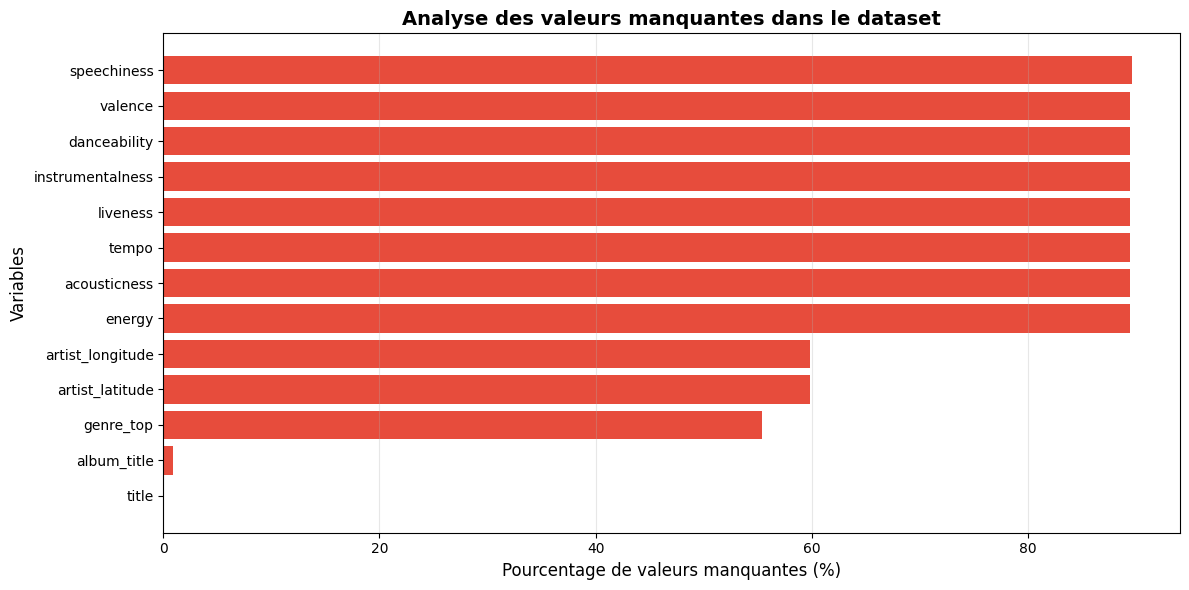

In [15]:

# Filtrer et trier
missing_to_plot = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage')

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(missing_to_plot.index, missing_to_plot['Percentage'], color='#e74c3c')

ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.set_title('Analyse des valeurs manquantes dans le dataset', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


- Les features dans Echonest (speechiness, valence, danceability, energy, liveness, acousticness, tempo, instrumentalness) sont absents pour environ 89% des morceaux.

- Les coordonnées géographiques de l’artiste (artist_latitude, artist_longitude) manquent dans environ 60% des cas.​

- Le genre principal genre_top est manquant pour plus de la moitié des pistes (~55%).

​-album_title et title ont très peu de valeurs manquantes (moins de 1%), ce qui est négligeable et peut être traité facilement (suppression ou imputation)


=== CORRÉLATION ENTRE MISSING VALUES ===

Nombre de variables avec missing values: 13

Corrélations fortes (> 0.5):
  speechiness <-> valence: 0.993
  speechiness <-> danceability: 0.993
  speechiness <-> energy: 0.992
  speechiness <-> liveness: 0.992
  speechiness <-> acousticness: 0.992
  speechiness <-> tempo: 0.992
  speechiness <-> instrumentalness: 0.992
  valence <-> danceability: 1.000
  valence <-> energy: 0.999
  valence <-> liveness: 0.999
  valence <-> acousticness: 0.999
  valence <-> tempo: 0.999
  valence <-> instrumentalness: 0.999
  danceability <-> energy: 0.999
  danceability <-> liveness: 0.999
  danceability <-> acousticness: 0.999
  danceability <-> tempo: 0.999
  danceability <-> instrumentalness: 0.999
  energy <-> liveness: 1.000
  energy <-> acousticness: 1.000
  energy <-> tempo: 1.000
  energy <-> instrumentalness: 1.000
  liveness <-> acousticness: 1.000
  liveness <-> tempo: 1.000
  liveness <-> instrumentalness: 1.000
  acousticness <-> tempo: 1.000
  a

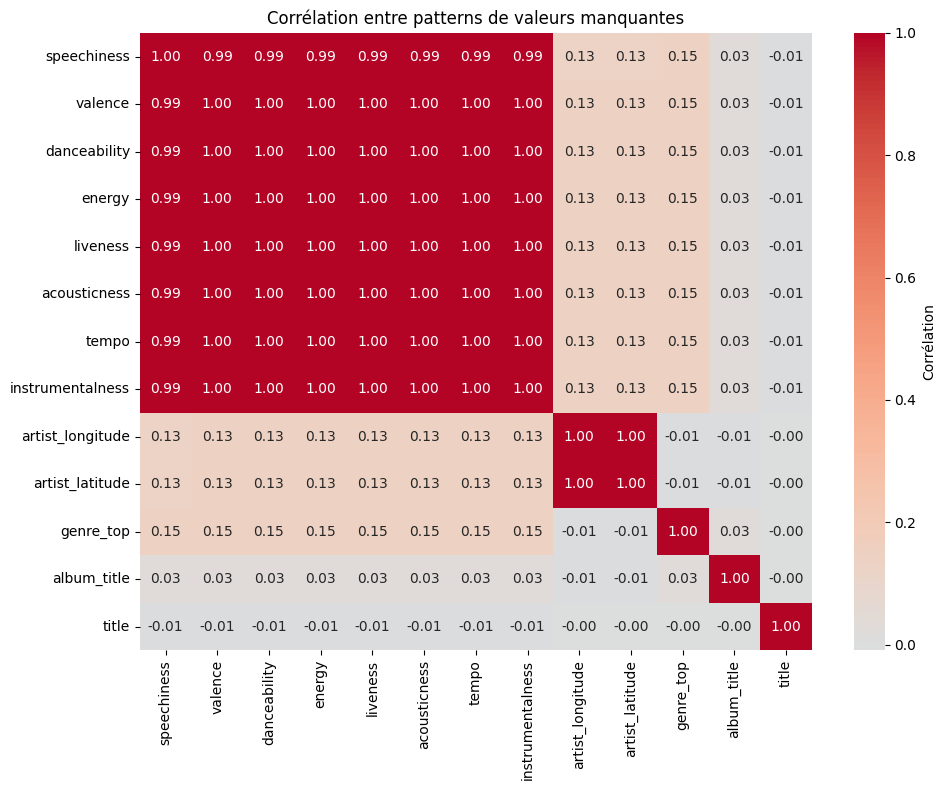

In [16]:
# Analyser si les missing values sont corrélés entre variables
print("\n=== CORRÉLATION ENTRE MISSING VALUES ===")
missing_cols = missing_df[missing_df['Missing_Count'] > 0].index.tolist()

if len(missing_cols) > 1:
    # Créer une matrice binaire (1 = missing, 0 = present)
    missing_matrix = df[missing_cols].isnull().astype(int)
    
    # Calculer la corrélation
    missing_corr = missing_matrix.corr()
    
    print(f"\nNombre de variables avec missing values: {len(missing_cols)}")
    print("\nCorrélations fortes (> 0.5):")
    
    # Afficher seulement les corrélations fortes
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            corr_val = missing_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                print(f"  {missing_corr.columns[i]} <-> {missing_corr.columns[j]}: {corr_val:.3f}")
    
    # Heatmap si pas trop de variables
    if len(missing_cols) <= 15:
        import seaborn as sns
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=ax, cbar_kws={'label': 'Corrélation'})
        plt.title('Corrélation entre patterns de valeurs manquantes')
        plt.tight_layout()
        plt.show()
else:
    print("Une seule variable a des missing values, pas de corrélation à calculer.")


- Les features de Echonest (speechiness, valence, danceability, energy, liveness, acousticness, tempo, instrumentalness) ont des valeurs manquantes quasi parfaitement corrélés, ce qui montre qu’ils sont tous absents ou présents en même temps pour une piste donnée.


- Même chose pour artist_latitude et artist_longitude. Ils ont une corrélation de 1.

- genre_top a un pattern de manquants faiblement corrélé aux autres colonnes, donc son absence est davantage liée au processus d’annotation.
​

In [17]:
# 3. Doublons
print(f"\nNombre de doublons (track_id): {df['track_id'].duplicated().sum()}")



Nombre de doublons (track_id): 0


In [18]:
# 4. Statistiques descriptives
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df[['duration', 'listens', 'interest', 'favorites']].describe())




=== STATISTIQUES DESCRIPTIVES ===
           duration        listens      interest     favorites
count  99995.000000   99995.000000  9.999500e+04  99995.000000
mean     278.034522    2403.072944  3.628631e+03      3.239962
std      294.940279    8234.085292  1.957852e+04     13.863871
min        0.000000       0.000000  2.000000e+00      0.000000
25%      151.000000     305.000000  6.020000e+02      0.000000
50%      218.000000     797.000000  1.333000e+03      1.000000
75%      307.000000    2085.000000  3.117000e+03      3.000000
max    11030.000000  543252.000000  3.293557e+06   1482.000000


In [19]:
print("\n" + "="*60)
print("DÉTECTION D'INCOHÉRENCES")
print("="*60)

# 1. DURÉE (variable cible pour Task 3)
print("\n--- DURÉE (duration) ---")
print(f"Durées négatives: {(df['duration'] < 0).sum()}")
print(f"Durées nulles (= 0): {(df['duration'] == 0).sum()}")
print(f"Durées très courtes (< 30s): {(df['duration'] < 30).sum()}")
print(f"Durées très longues (> 600s = 10min): {(df['duration'] > 600).sum()}")
print(f"Durées extrêmes (> 3600s = 1h): {(df['duration'] > 3600).sum()}")
print(f"\nMin duration: {df['duration'].min()}s")
print(f"Max duration: {df['duration'].max()}s")

# 2. COORDONNÉES GPS
print("\n--- COORDONNÉES GPS ---")
if 'artist_latitude' in df.columns and 'artist_longitude' in df.columns:
    print(f"Latitudes hors [-90, 90]: {((df['artist_latitude'] < -90) | (df['artist_latitude'] > 90)).sum()}")
    print(f"Longitudes hors [-180, 180]: {((df['artist_longitude'] < -180) | (df['artist_longitude'] > 180)).sum()}")
    print(f"Coordonnées (0, 0) - probablement invalides: {((df['artist_latitude'] == 0) & (df['artist_longitude'] == 0)).sum()}")

# 3. FEATURES ECHONEST (doivent être entre 0 et 1)
print("\n--- FEATURES ECHONEST (doivent être [0, 1]) ---")
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'speechiness', 'valence']

for feat in audio_features:
    if feat in df.columns:
        out_of_range = ((df[feat] < 0) | (df[feat] > 1)).sum()
        if out_of_range > 0:
            print(f"  ⚠️ {feat} hors [0,1]: {out_of_range} valeurs")
        else:
            print(f"  ✓ {feat}: OK")

# 4. TEMPO (devrait être positif et raisonnable)
print("\n--- TEMPO ---")
if 'tempo' in df.columns:
    print(f"Tempo négatif: {(df['tempo'] < 0).sum()}")
    print(f"Tempo = 0: {(df['tempo'] == 0).sum()}")
    print(f"Tempo très élevé (> 300 BPM): {(df['tempo'] > 300).sum()}")
    print(f"Range: [{df['tempo'].min():.1f}, {df['tempo'].max():.1f}] BPM")

# 5. FEATURES SPECTRALES (vérifier valeurs infinies/NaN)
print("\n--- FEATURES SPECTRALES ---")
spectral_cols = [col for col in df.columns if 'spectral' in col]
if spectral_cols:
    print(f"Valeurs infinies: {np.isinf(df[spectral_cols]).sum().sum()}")
    print(f"NaN dans spectrales (en plus des missing): {df[spectral_cols].isna().sum().sum()}")
    
    # Vérifier valeurs négatives (certaines features peuvent être négatives)
    negative_spectral = (df[spectral_cols] < 0).sum().sum()
    print(f"Valeurs négatives: {negative_spectral}")

# 6. STATISTIQUES D'ÉCOUTE
print("\n--- STATISTIQUES D'ÉCOUTE ---")
if 'listens' in df.columns:
    print(f"Listens négatifs: {(df['listens'] < 0).sum()}")
    print(f"Listens = 0: {(df['listens'] == 0).sum()}")
    
if 'interest' in df.columns:
    print(f"Interest négatif: {(df['interest'] < 0).sum()}")
    print(f"Interest = 0: {(df['interest'] == 0).sum()}")

if 'favorites' in df.columns:
    print(f"Favorites négatifs: {(df['favorites'] < 0).sum()}")

# 7. GENRE_TOP (variable cible Task 1)
print("\n--- GENRE_TOP (target Task 1) ---")
print(f"Genre_top manquants: {df['genre_top'].isnull().sum()}")
print(f"Genres uniques: {df['genre_top'].nunique()}")



DÉTECTION D'INCOHÉRENCES

--- DURÉE (duration) ---
Durées négatives: 0
Durées nulles (= 0): 4
Durées très courtes (< 30s): 1754
Durées très longues (> 600s = 10min): 5527
Durées extrêmes (> 3600s = 1h): 123

Min duration: 0s
Max duration: 11030s

--- COORDONNÉES GPS ---
Latitudes hors [-90, 90]: 0
Longitudes hors [-180, 180]: 0
Coordonnées (0, 0) - probablement invalides: 0

--- FEATURES ECHONEST (doivent être [0, 1]) ---
  ✓ acousticness: OK
  ✓ danceability: OK
  ✓ energy: OK
  ✓ instrumentalness: OK
  ✓ liveness: OK
  ✓ speechiness: OK
  ✓ valence: OK

--- TEMPO ---
Tempo négatif: 0
Tempo = 0: 19
Tempo très élevé (> 300 BPM): 0
Range: [0.0, 251.1] BPM

--- FEATURES SPECTRALES ---
Valeurs infinies: 0
NaN dans spectrales (en plus des missing): 0
Valeurs négatives: 94478

--- STATISTIQUES D'ÉCOUTE ---
Listens négatifs: 0
Listens = 0: 1
Interest négatif: 0
Interest = 0: 0
Favorites négatifs: 0

--- GENRE_TOP (target Task 1) ---
Genre_top manquants: 55362
Genres uniques: 16


- Les durées ne présentent pas d’erreurs grossières : aucune valeur négative, seulement 4 morceaux à 0 seconde, mais plusieurs milliers de titres très courts (< 30s) ou très longs (> 10 minutes, voire > 1h), qui ressemblent plutôt à des outliers plausibles qu’à des bugs.

- Les coordonnées GPS sont propres : aucune latitude hors [−90,90][−90,90], aucune longitude hors [−180,180][−180,180].

- Les features Echonest censées être dans [0,1] (acousticness, danceability, energy, instrumentalness, etc.) respectent bien cette contrainte, donc pas de problème de normalisation.

- Les valeurs de tempo sont toutes positives, sans tempo égal à 0 et sans valeurs extrêmes au‑delà de 300 BPM, ce qui reste raisonnable pour de la musique enregistrée.

- Les features spectrales ne contiennent ni infini ni NaN supplémentaires, et la présence de valeurs négatives semble normale pour ce type de statistiques, donc pas de souci particulier de qualité ici non plus.

- Les variables d’écoute (listens, favorites, interest) n’ont pas de valeurs négatives, mais beaucoup de 0, ce qui reflète simplement des morceaux peu ou pas écoutés. 

- genre_top ne présente que des incohérences de complétude : plus de 55 000 valeurs manquantes et 16 genres différents parmi les lignes renseignées.

 ## 3. Statistiques descriptives uni- et multi-variées

### 3.1 Statistiques univariées 

In [20]:
# Statistiques descriptives des variables numériques :
# - moyenne, écart-type, min, max, quartiles

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols].describe().T  # .T pour avoir une vue plus lisible


,count,mean,std,min,25%,50%,75%,max
album_tracks,99995.0,19.908645,40.510849,-1.000000e+00,7.000000,11.000000,18.000000,6.520000e+02
artist_latitude,40207.0,39.967832,18.766913,-4.587450e+01,39.271398,41.823989,50.079079,6.728601e+01
artist_longitude,40207.0,-35.443236,65.670545,-1.575269e+02,-78.868915,-72.669067,5.007986,1.752770e+02
duration,99995.0,278.034522,294.940279,0.000000e+00,151.000000,218.000000,307.000000,1.103000e+04
favorites,99995.0,3.239962,13.863871,0.000000e+00,0.000000,1.000000,3.000000,1.482000e+03
interest,99995.0,3628.631112,19578.522967,2.000000e+00,602.000000,1333.000000,3117.000000,3.293557e+06
listens,99995.0,2403.072944,8234.085292,0.000000e+00,305.000000,797.000000,2085.000000,5.432520e+05
acousticness,10553.0,0.489379,0.384781,9.491000e-07,0.070923,0.486664,0.897625,9.957965e-01
danceability,10534.0,0.506784,0.189812,5.143514e-02,0.367335,0.511994,0.651299,9.686447e-01
energy,10553.0,0.541650,0.274799,2.028170e-05,0.330205,0.554549,0.774238,9.999637e-01


- Les variables principales ont une durée médiane d’environ 3–4 minutes et un nombre d’écoutes très asymétrique = présence de nombreux morceaux peu écoutés et de quelques très gros succès.


- Les features audio Echonest et spectrales sont en échelle continue entre 0 et 1, sans valeurs extrêmes évidentes, ce qui indique qu’elles ont déjà été normalisées.
​

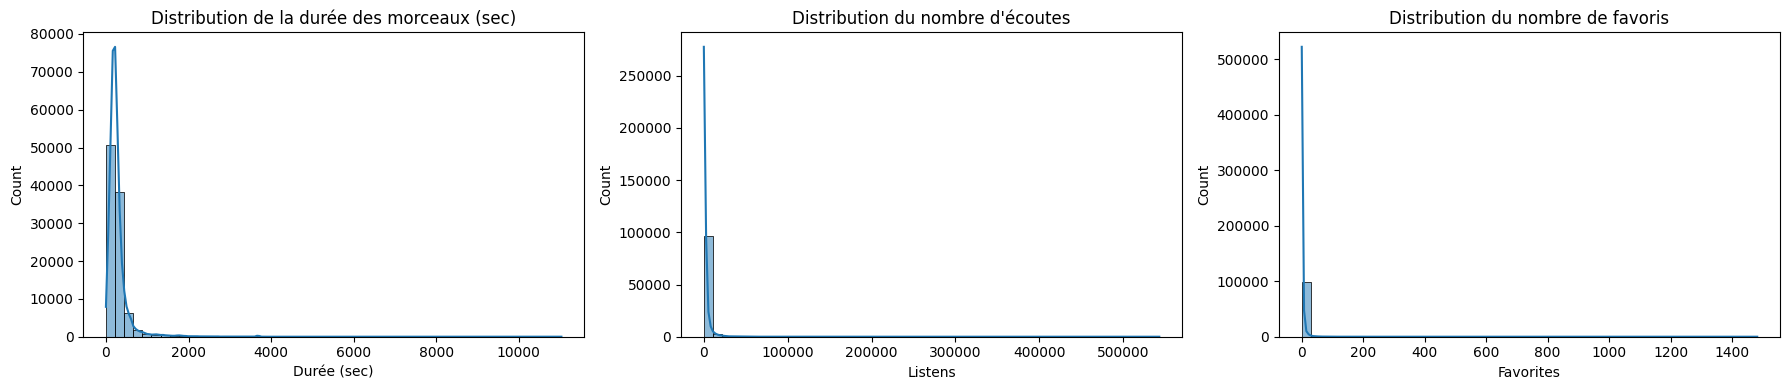

In [21]:
# Visualisation des distributions pour quelques variables clés 

fig, axes = plt.subplots(1, 3, figsize=(18,4))

sns.histplot(df["duration"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Distribution de la durée des morceaux (sec)")
axes[0].set_xlabel("Durée (sec)")

sns.histplot(df["listens"], bins=50, ax=axes[1], kde=True)
axes[1].set_title("Distribution du nombre d'écoutes")
axes[1].set_xlabel("Listens")

sns.histplot(df["favorites"], bins=50, ax=axes[2], kde=True)
axes[2].set_title("Distribution du nombre de favoris")
axes[2].set_xlabel("Favorites")

plt.tight_layout()
plt.show()

-Présence de quelques outliers

### 3.2 Analyse de la structure des genres


Effectifs par genre_top :
genre_top
NaN                    55362
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64


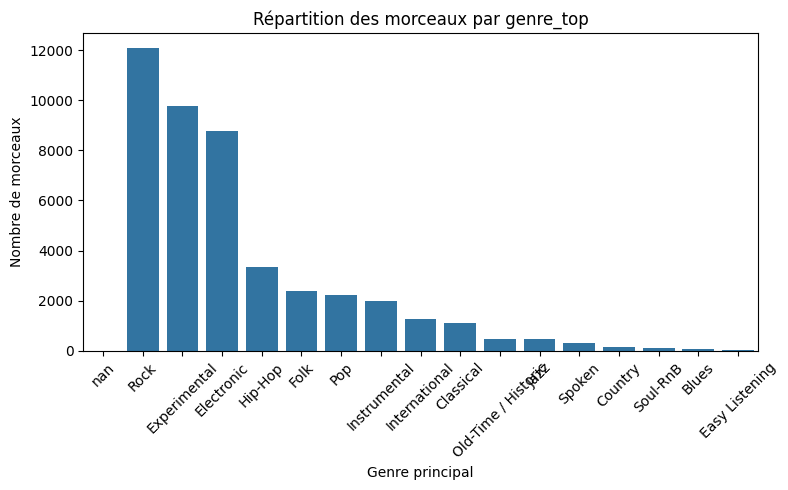

In [22]:
# Répartition des morceaux par genre_top (étiquette principale).
# On regarde d'abord les effectifs, puis on trace un barplot.

genre_counts = df["genre_top"].value_counts(dropna=False)
print("Effectifs par genre_top :")
print(genre_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="genre_top", order=genre_counts.index)
plt.title("Répartition des morceaux par genre_top")
plt.xlabel("Genre principal")
plt.ylabel("Nombre de morceaux")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Jeu de données est très déséquilibré au niveau de genre_top.
- Plus de la moitié des morceaux n’ont pas de genre principal renseigné (NaN ≈ 55 000).
- Parmi ceux qui ont un genre principal, quelques genres dominent largement (Rock, Experimental, Electronic) alors que d’autres sont très rares (Blues, Easy Listening, Soul-RnB, Country). -> Nécessité de regrouper certains genres plus tard.
​

### 3.3 Statistiques multi-variées


                     count        mean  median
genre_top                                     
Spoken                 323  678.603715   240.0
Jazz                   484  378.723140   310.5
Experimental          9752  367.719647   263.0
Classical             1129  303.235607   190.0
International         1256  292.592357   236.0
Easy Listening          24  289.291667   199.0
Soul-RnB               131  265.984733   239.0
Electronic            8769  264.536663   242.0
Blues                   79  251.987342   228.0
Instrumental          2003  246.071393   192.0
Rock                 12085  222.914770   190.0
Folk                  2375  218.777684   202.0
Hip-Hop               3334  202.440612   201.0
Country                163  200.128834   191.0
Pop                   2235  186.919911   187.0
Old-Time / Historic    491  179.692464   170.0


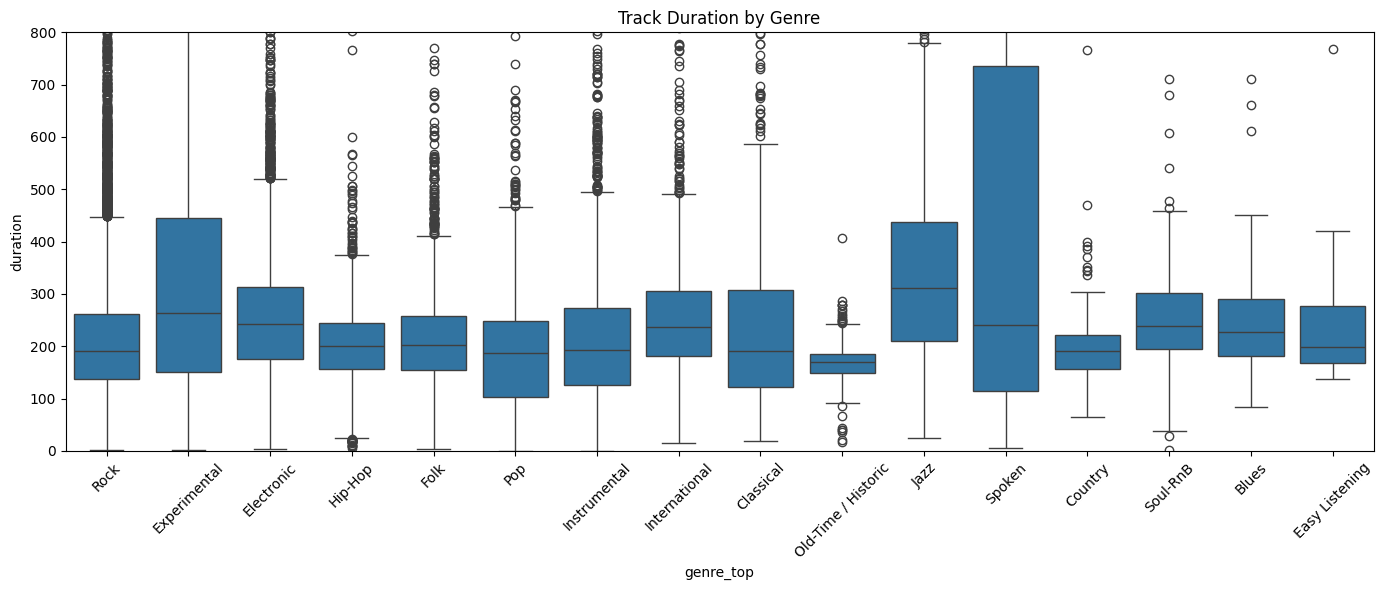

In [23]:
# Durée moyenne des morceaux par genre_top.

duration_by_genre = df.groupby("genre_top")["duration"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
print(duration_by_genre)


#Boxplot duration vs genre_top

plt.figure(figsize=(14, 6))
sns.boxplot(
    x="genre_top",
    y="duration",
    data=df,
    order=df["genre_top"].value_counts().index
)
plt.title("Track Duration by Genre")
plt.xticks(rotation=45)
plt.ylim(0, 800)
plt.tight_layout()
plt.show()


### Analyse de la durée des morceaux par genre

Le tableau Track Duration by Genre ainsi que le boxplot mettent en évidence une hiérarchie claire dans la structure temporelle des morceaux selon leurs genres. Trois grandes catégories se distinguent.


#### Morceaux longs et complexes : *Classical, Jazz, Spoken, Experimental*

- Le genre spoken est de loin la plus longue en moyenne, avec environ 678 secondes (≈ 11 min).
- Elle est suivie par le jazz, avec une durée moyenne d’environ 378 secondes (≈ 6 minutes).
- Les boxplots montrent pour ces genres, en particulier pour le classique, des boîtes très étirées et de nombreux outliers vers le haut.
- Cela indique une forte variabilité des durées. Il n'y a pas de format standard : un morceau peut durer aussi bien 2 minutes que plus de 20 minutes.



#### Formats standards : *Rock, Blues, Electronic*

- Ces genres présentent des durées moyennes comprises entre 220 et 265 secondes .
- Les boxplots sont plus resserrés, ce qui traduit une forte standardisation du format.


#### Morceaux courts : *Hip-Hop, Old-Time*

- Le Hip-Hop est relativement court en moyenne, avec environ 191 secondes (≈ 3 minutes).
- Cette caractéristique s’explique notamment par :
- Le genre *Old-Time* suit également cette logique de formats courts et compacts.




L’analyse montre que la durée des morceaux est fortement dépendante du genre musical.  



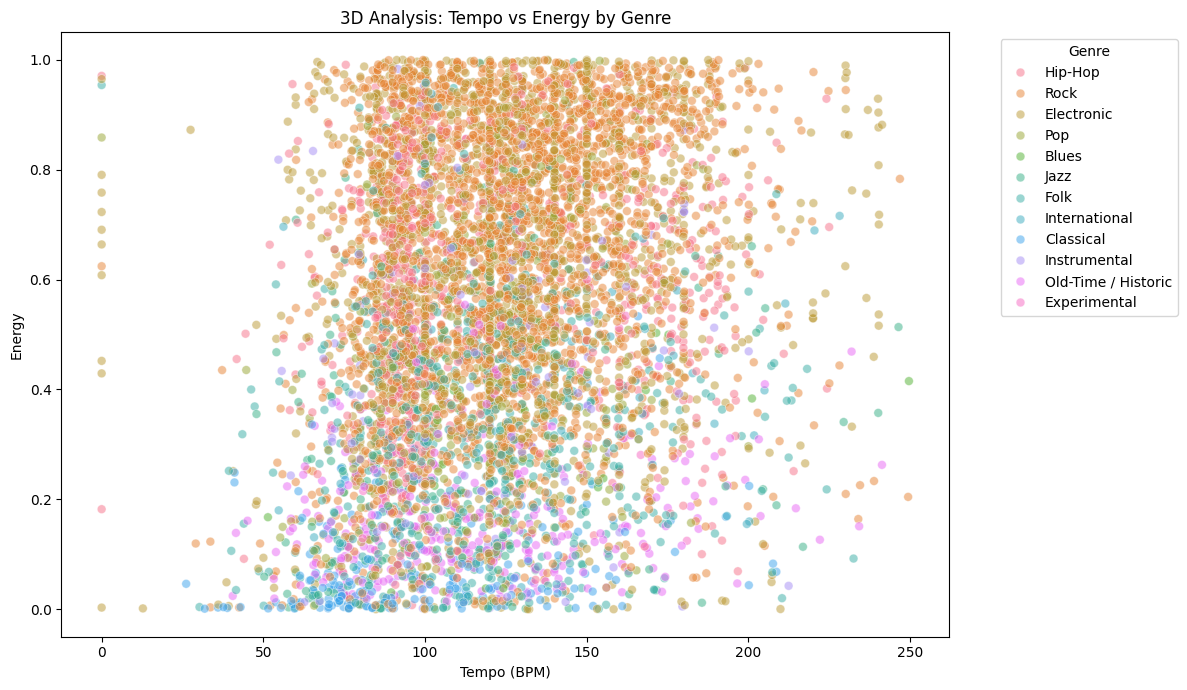

In [24]:

# 6. 3D MULTI-DIMENSIONAL ANALYSIS Tempo vs Energy by genre
required_cols = ["tempo", "energy", "genre_top"]

if all(col in df.columns for col in required_cols):

    df_plot = df[required_cols].dropna()

    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=df_plot,
        x="tempo",
        y="energy",
        hue="genre_top",
        alpha=0.5,
        s=40
    )

    plt.title("3D Analysis: Tempo vs Energy by Genre")
    plt.xlabel("Tempo (BPM)")
    plt.ylabel("Energy")
    plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("Colonnes manquantes pour l'analyse 3D :", required_cols)






### Analyse multivariée : relation entre le tempo, l'énergie par le genre

Ce graphique croise la vitesse (tempo) et l’intensité sonore (energy) des morceaux, en fonction de leur genre musical. Il montre que l'énergie est un facteur discriminant.


#### L'énergie comme variable discriminante principale

Une séparation nette apparaît selon la valeur de l’energy :

- Zone de haute énergie :
  - On y retrouve majoritairement les genres Rock, Electronic et Hip-Hop.
  - Ces styles se caractérisent par une forte intensité sonore.

- Zone de basse énergie :
  - Elle regroupe principalement le Folk, le Classical, le Old-Time et le Jazz.
  - Ces genres sont en général plus calmes et acoustiques


Quant au tempo, il est fortement dispersé pour l’ensemble des genres.



L’analyse révèle que l’énergie constitue un facteur bien plus discriminant que le tempo pour différencier les genres musicaux. Le BPM intervient comme un paramètre complémentaire, mais il ne suffit pas, à lui seul, à définir le genre musical.


In [25]:
# PCA 

audio_features = [
    'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'speechiness',
    'valence', 'tempo', 'loudness'
]

audio_features = [f for f in audio_features if f in df.columns]

df_pca = df[audio_features + ["genre_top"]].dropna()

X = df_pca[audio_features]
y = df_pca["genre_top"]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca_vis = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca_vis["genre_top"] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pca_vis,
    x="PC1",
    y="PC2",
    hue="genre_top",
    alpha=0.5
)
plt.title("PCA Projection of Audio Features (2D)")
plt.tight_layout()
plt.show()

print("Explained Variance Ratio:", pca.explained_variance_ratio_)





NameError: name 'StandardScaler' is not defined

On effectue un PCA pour compressé toutes les infos en 2 axes (PC1 et PC2) pour visualiser qui ressemble à qui.

### Axe Horizontal (PC1 - Probablement "Acoustique vs Électrique") :

- À droite/haut : amas de Rock et Electronic .  
- À gauche/bas : Classique, Folk, et Old-Time.

Cela confirme qu'il y a deux "mondes" de musique :  
instruments acoustiques naturels vs instruments amplifiés/digitaux.

### Zone de confusion :

- Au centre : tout se mélange un peu (Pop, International).  
Ces genres empruntent des caractéristiques aux deux mondes, ce qui les rend difficiles à classifier mathématiquement juste avec le son.

### Axe Verticale (PC2 - Probablement "Vocale vs Instrumental") :

En bas, on retrouve plutôt les genres musicaux sans voix et instrumentaux alors qu'en haut on trouve les genre vocaux.


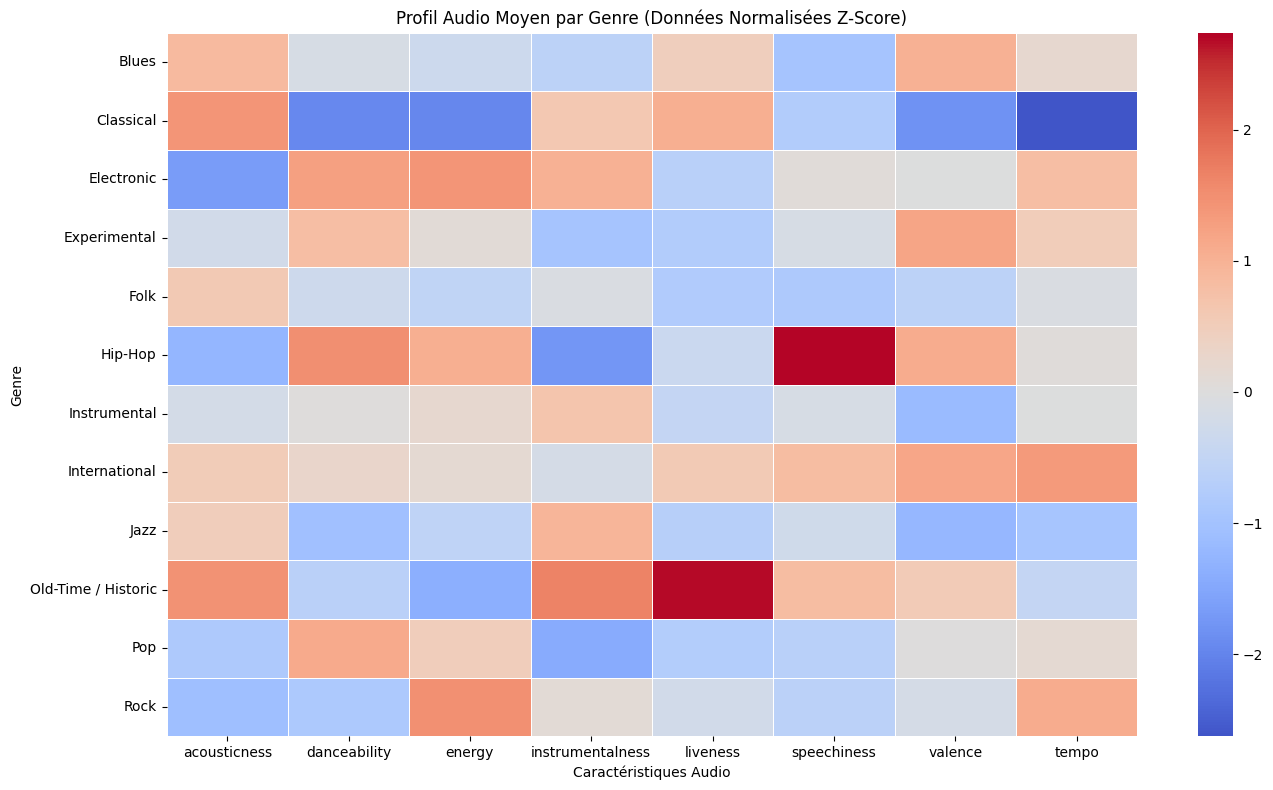

In [ ]:
#MEAN AUDIO FEATURES BY GENRE (HEATMAP)


# Calcul des moyennes brutes par genre
df_genre_means = df.groupby("genre_top")[audio_features].mean()

# Normalisation Z-Score (Standardisation) des moyennes

scaler = StandardScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_genre_means),
    columns=df_genre_means.columns,
    index=df_genre_means.index
)
  

max_abs_deviation = df_normalized.abs().max(axis=1)
threshold = 0.4
df_filtered = df_normalized[max_abs_deviation >= threshold]

df_normalized = df_filtered

# Génération de la Heatmap normalisée

plt.figure(figsize=(14, 8))
sns.heatmap(
    df_normalized,
    cmap="coolwarm",
    linewidths=0.5,
    center=0, 
    annot=False 
)
plt.title("Profil Audio Moyen par Genre (Données Normalisées Z-Score)")
plt.xlabel("Caractéristiques Audio")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

## 4. Heatmap (Mean Audio Features)

C'est l'empreinte digitale de chaque genre, cette heatmap permet de voir les caractéristiques de chacun d'entre eux de manière résumée.

- **Hip-Hop** :  
  La colonne speechiness est rouge vif, ce qui est logique pour le rap.  
  Il est aussi élevé en danceability.

- **Classical** :  
  Rouge sur acousticness et instrumentalness (acoustique et sans chanteur).  
  Bleu foncé sur energy (dynamique naturelle, pas compressée comme dans le pop/rock).

- **Rock & Electronic** :  
  Rouge sur energy. Ce sont les genres les plus "bruyants" et intenses.

- **Jazz** :  
  Genre "hybride" : assez instrumental et acoustique, mais plus dansant et énergique que le Classique.

### Résumé

- La durée distingue surtout le Classique/Jazz des autres genres.  
- L’énergie et l’acoustique sont les meilleurs critères pour séparer le monde "Moderne/Amplifié" (Rock, Electro, Hip-Hop) du monde "Traditionnel" (Folk, Classique).


 ## 4. Recodage et création de nouvelles variables

In [ ]:
# 4.1 Transformations de variables numériques

# Log-transform pour réduire l'asymétrie des distributions
df["log_duration"] = np.log1p(df["duration"])
df["log_listens"] = np.log1p(df["listens"])
df["log_favorites"] = np.log1p(df["favorites"])

# Durée en minutes (plus interprétable)
df["duration_min"] = df["duration"] / 60

# Ratio favoris / écoutes (popularité conditionnelle)
df["favorites_per_listen"] = df["favorites"] / (df["listens"] + 1)


In [ ]:
# 4.2 Encodage de la variable cible genre_top

# On garde uniquement les lignes avec genre_top renseigné pour la future classification
df_classif = df[~df["genre_top"].isna()].copy()

# Vérification des classes
genre_counts = df_classif["genre_top"].value_counts()
genre_counts


genre_top
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64

In [ ]:
# Encodage label -> entier (si besoin)
from sklearn.preprocessing import LabelEncoder

le_genre = LabelEncoder()
df_classif["genre_encoded"] = le_genre.fit_transform(df_classif["genre_top"])


In [ ]:
# 4.3 Sous-ensemble avec toutes les features Echonest disponibles

echonest_cols = ["acousticness", "danceability", "energy", "instrumentalness",
                 "liveness", "speechiness", "valence", "tempo"]

df_audio = df_classif.dropna(subset=echonest_cols).copy()
print("Taille du sous-ensemble audio complet :", df_audio.shape)


Taille du sous-ensemble audio complet : (6867, 51)


En filtrant les morceaux pour lesquels toutes les features Echonest sont présentes, on obtient un sous-ensemble de 6 867 pistes seulement, contre près de 100 000 au départ. Cela confirme que les descripteurs audio de haut niveau ne sont disponibles que pour une minorité du catalogue.

## 5. Resume

- Le notebook construit un dataset fusionné propre en combinant métadonnées, features Echonest et spectrales, avec un enrichissement des genres via la taxonomie fournie.

- Les variables centrales (duration, listens, favorites, interest…) sont complètes, tandis que genre_top, les features Echonest et les coordonnées GPS sont très partiellement renseignées, avec des patterns de valeurs manquantes fortement corrélés au sein de chaque bloc.


- df : dataframe principal fusionné (tracks + Echonest + spectrales + genres correspondants), à utiliser pour toute exploration ou feature engineering général.

- df_classif : sous-ensemble de df sans NaN sur genre_top.

- df_audio : sous-ensemble de df_classif sans missing value sur les features echonest
​

In [ ]:
df.to_csv("df_phase1.csv", index=False) #merge de df mais avec les noms de genre

In [ ]:
df_classif.to_csv("df_classif_phase1.csv", index=False) #sous ensemble de df sans les valeurs manquantes sur genre_top

In [ ]:
df_audio.to_csv("df_audio_phase1.csv", index=False) #sous ensemble de df_classif sans les valeurs manquantes sur features de echonest